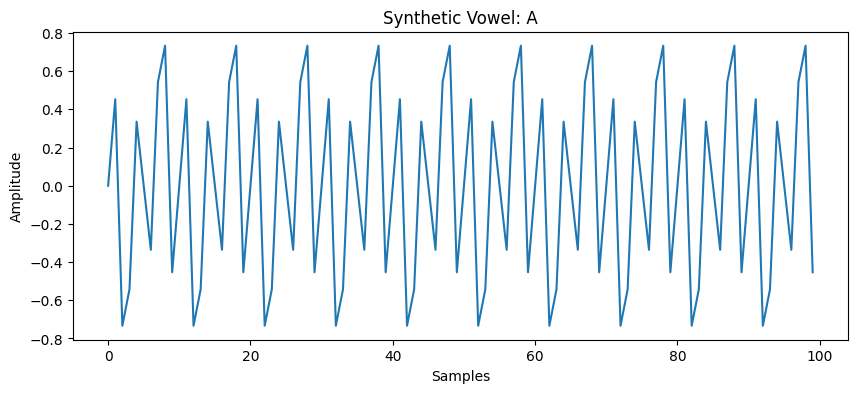

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
def generate_vowel(f1, f2, f3, duration=1.0, sampling_rate=16000):
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    vowel_signal = 0.6 * np.sin(2 * np.pi * f1 * t) + \
                   0.3 * np.sin(2 * np.pi * f2 * t) + \
                   0.1 * np.sin(2 * np.pi * f3 * t)

    return vowel_signal

sampling_rate = 100
duration = 1.0

formants = {
    'a': (730, 1090, 2440),
}

vowel_signals = {vowel: generate_vowel(*f, duration, sampling_rate) for vowel, f in formants.items()}

for vowel, signal in vowel_signals.items():
    plt.figure(figsize=(10, 4))
    plt.plot(signal[:1000])
    plt.title(f'Synthetic Vowel: {vowel.upper()}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()

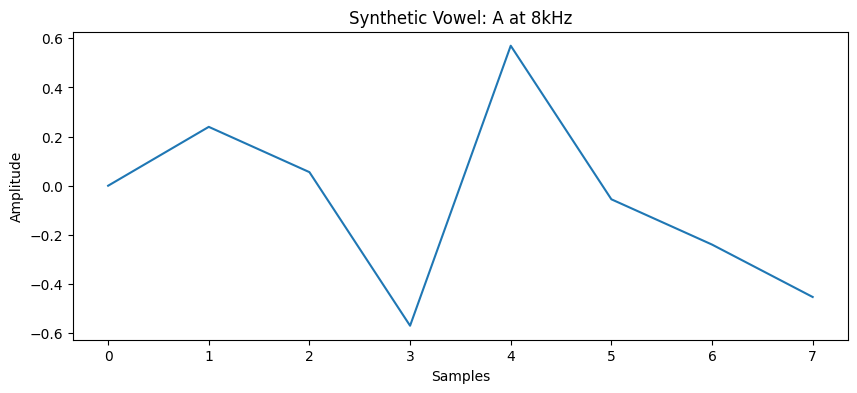

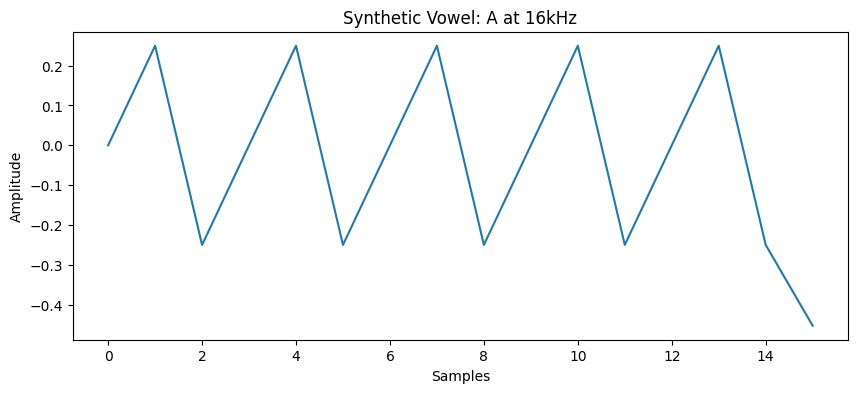

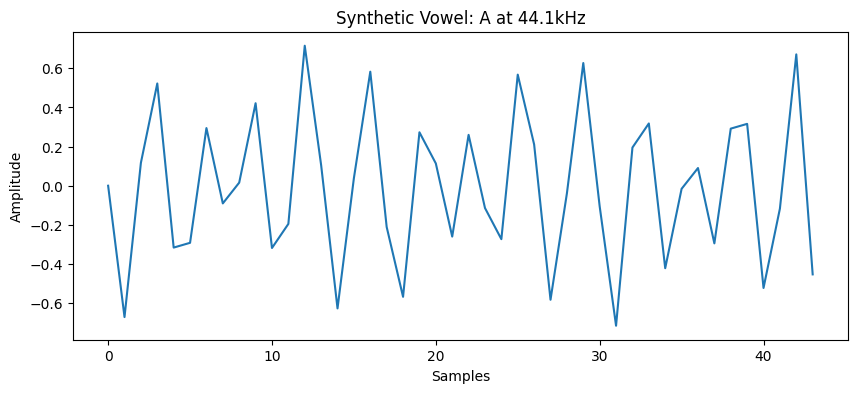

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
sampling_rates = [8, 16, 44.1]
for sampling_rate in sampling_rates:
  for vowel, signal in vowel_signals.items():
      duration = len(signal) / 100
      new_length = int(duration * sampling_rate)
      resampled_signal = np.interp(np.linspace(0, len(signal), new_length), np.arange(len(signal)), signal)

      plt.figure(figsize=(10, 4))
      plt.plot(resampled_signal[:1000])
      plt.title(f'Synthetic Vowel: {vowel.upper()} at {sampling_rate}kHz')
      plt.xlabel('Samples')
      plt.ylabel('Amplitude')
      plt.show()

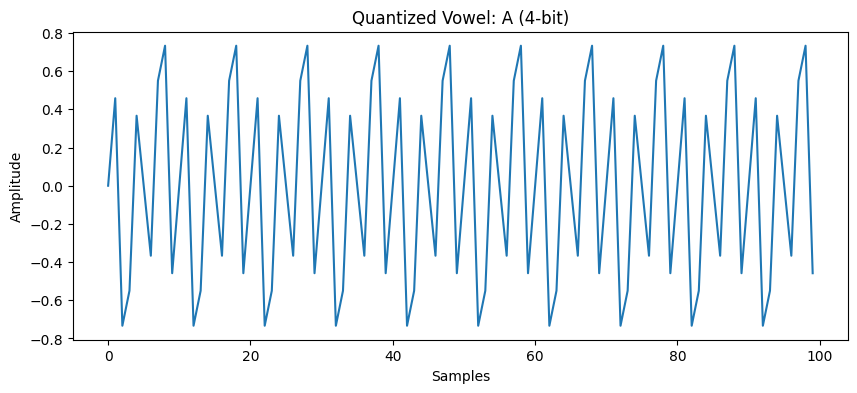

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
bits = 4
levels = 2**bits
for vowel, signal in vowel_signals.items():
  min_val = np.min(signal)
  max_val = np.max(signal)
  step_size = (max_val - min_val) / levels
  quantized_signal = np.round((signal - min_val) / step_size) * step_size + min_val
  plt.figure(figsize=(10, 4))
  plt.plot(quantized_signal[:1000])
  plt.title(f'Quantized Vowel: {vowel.upper()} ({bits}-bit)')
  plt.xlabel('Samples')
  plt.ylabel('Amplitude')
  plt.show()

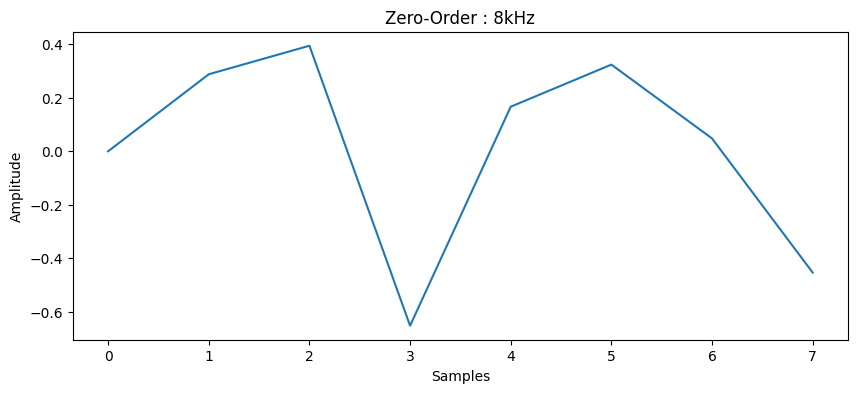

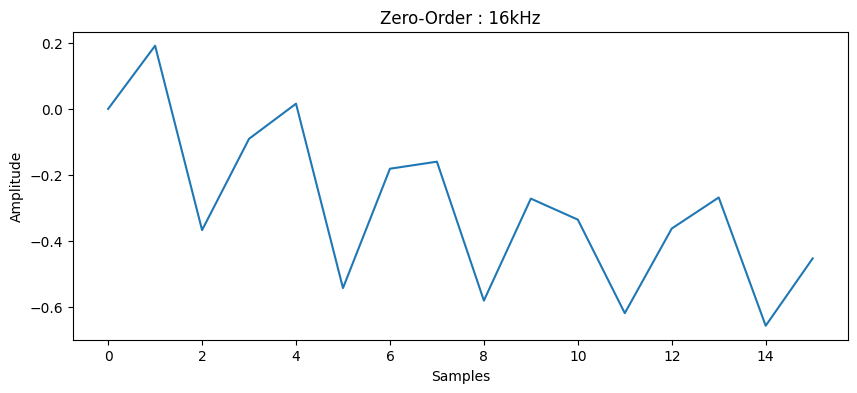

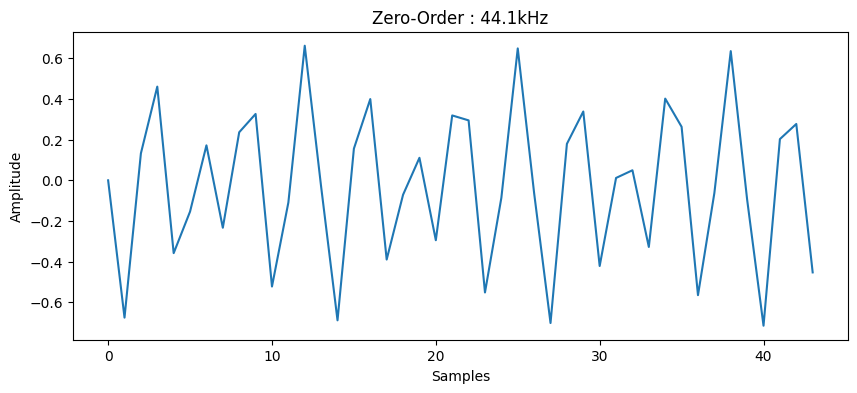

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def zero_order_hold(signal, original_sampling_rate, new_sampling_rate):
  duration = len(signal) / original_sampling_rate
  new_length = int(duration * new_sampling_rate)
  new_time = np.linspace(0, duration, new_length)
  original_time = np.linspace(0, duration, len(signal))
  reconstructed_signal = np.interp(new_time, original_time, signal, left=signal[0], right=signal[-1])
  return reconstructed_signal

for sampling_rate in sampling_rates:
  for vowel, signal in vowel_signals.items():
    reconstructed_signal = zero_order_hold(signal, 100, sampling_rate)
    plt.figure(figsize=(10, 4))
    plt.plot(reconstructed_signal[:1000])
    plt.title(f'Zero-Order : {sampling_rate}kHz')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()

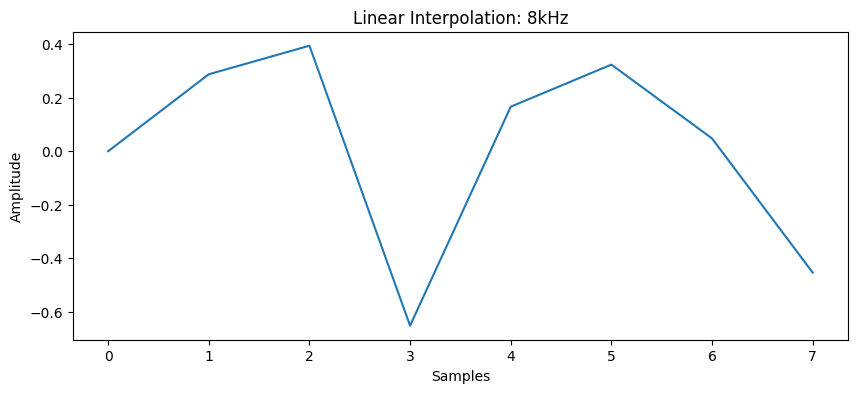

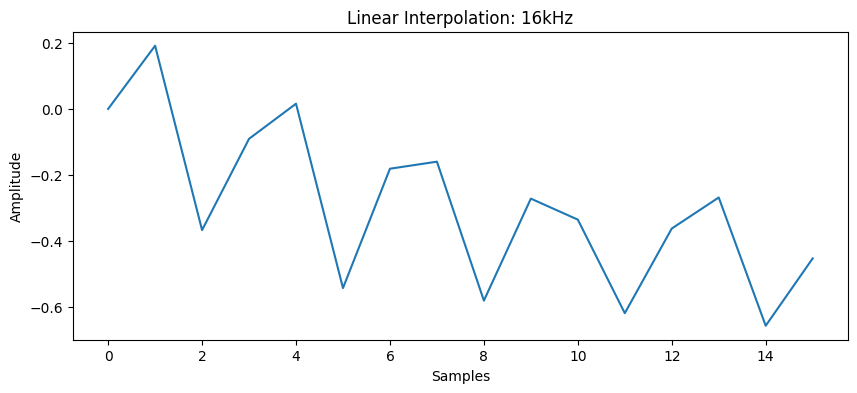

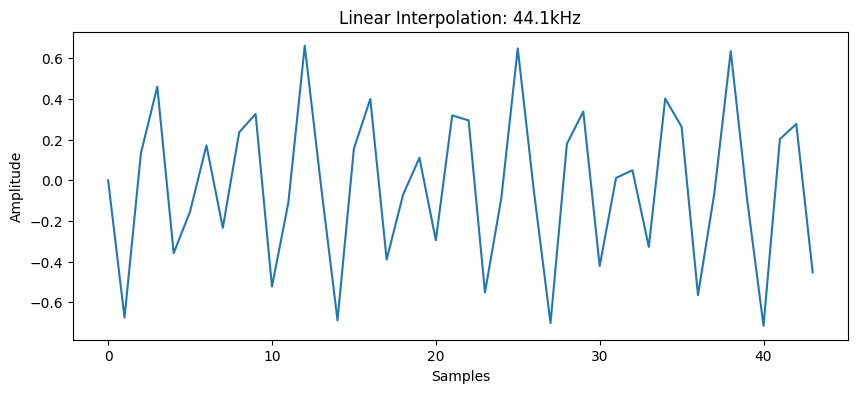

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def linear_interpolation(signal, original_sampling_rate, new_sampling_rate):
  duration = len(signal) / original_sampling_rate
  new_length = int(duration * new_sampling_rate)
  new_time = np.linspace(0, duration, new_length)
  original_time = np.linspace(0, duration, len(signal))
  reconstructed_signal = np.interp(new_time, original_time, signal)
  return reconstructed_signal

for sampling_rate in sampling_rates:
  for vowel, signal in vowel_signals.items():
    reconstructed_signal = linear_interpolation(signal, 100, sampling_rate)
    plt.figure(figsize=(10, 4))
    plt.plot(reconstructed_signal[:1000])
    plt.title(f'Linear Interpolation: {sampling_rate}kHz')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()

In [ ]:
def calculate_mse(original_signal, reconstructed_signal):
    """Calculates the Mean Squared Error (MSE) between two signals."""
    min_length = min(len(original_signal), len(reconstructed_signal))
    return np.mean((original_signal[:min_length] - reconstructed_signal[:min_length]) ** 2)

for sampling_rate in sampling_rates:
    for vowel, signal in vowel_signals.items():
        reconstructed_signal_zoh = zero_order_hold(signal, 100, sampling_rate)
        reconstructed_signal_linear = linear_interpolation(signal, 100, sampling_rate)

        mse_zoh = calculate_mse(signal, reconstructed_signal_zoh)
        mse_linear = calculate_mse(signal, reconstructed_signal_linear)

        print(f"Sampling Rate: {sampling_rate}kHz")
        print(f"  MSE (Zero-Order Hold): {mse_zoh}")
        print(f"  MSE (Linear Interpolation): {mse_linear}")

Sampling Rate: 8kHz
  MSE (Zero-Order Hold): 0.32278266767988223
  MSE (Linear Interpolation): 0.32278266767988223
Sampling Rate: 16kHz
  MSE (Zero-Order Hold): 0.35911286070984977
  MSE (Linear Interpolation): 0.35911286070984977
Sampling Rate: 44.1kHz
  MSE (Zero-Order Hold): 0.4336708007889452
  MSE (Linear Interpolation): 0.4336708007889452


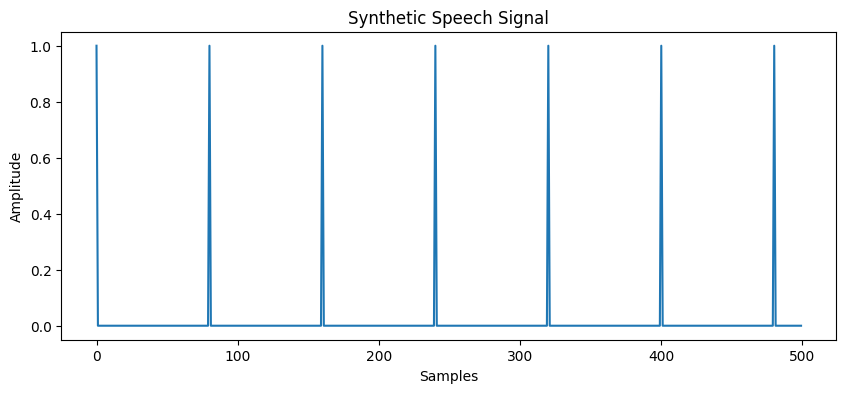

In [ ]:
from scipy.signal import lfilter

def generate_excitation(duration=1.0, sampling_rate=16000):
  """Generates a periodic pulse train as the excitation signal."""
  t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
  excitation = np.zeros_like(t)
  pulse_period = 0.005  # 200 Hz pulse rate
  for i in range(int(duration / pulse_period)):
    excitation[int(i * sampling_rate * pulse_period)] = 1.0
  return excitation

def generate_vocal_tract_filter(formants, bandwidths, sampling_rate=16000):
  """Generates a digital filter representing the vocal tract."""
  b = [1.0]
  a = [1.0]
  for formant, bandwidth in zip(formants, bandwidths):
    w0 = 2 * np.pi * formant / sampling_rate
    alpha = bandwidth / 2
    a.append(-2 * np.exp(-alpha) * np.cos(w0))
    a.append(np.exp(-2 * alpha))
  return b, a
formants = [730, 1090, 2440]
bandwidths = [50, 50, 50]
sampling_rate = 16000
duration = 1.0
excitation = generate_excitation(duration, sampling_rate)
b, a = generate_vocal_tract_filter(formants, bandwidths, sampling_rate)
speech_signal = lfilter(b, a, excitation)

plt.figure(figsize=(10, 4))
plt.plot(speech_signal[:500])
plt.title('Synthetic Speech Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

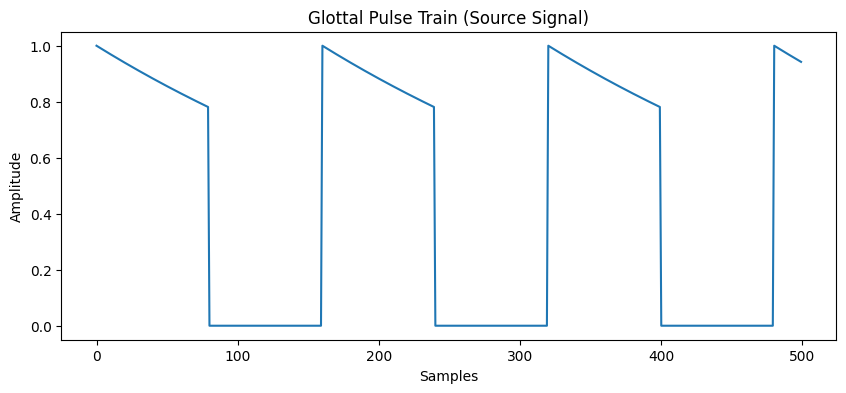

In [ ]:
def generate_glottal_pulse_train(duration=1.0, sampling_rate=16000, pitch=100):
  """Generates a glottal pulse train as the excitation signal."""
  t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
  excitation = np.zeros_like(t)
  pulse_period = 1 / pitch
  for i in range(int(duration / pulse_period)):
    pulse_start = int(i * sampling_rate * pulse_period)
    pulse_end = int(min(pulse_start + sampling_rate * 0.005, len(excitation)))  # Pulse duration
    excitation[pulse_start:pulse_end] = np.exp(-50 * (np.arange(pulse_end - pulse_start) / sampling_rate))
  return excitation

sampling_rate = 16000
duration = 1.0
pitch = 100  # Hz
source_signal = generate_glottal_pulse_train(duration, sampling_rate, pitch)

plt.figure(figsize=(10, 4))
plt.plot(source_signal[:500])
plt.title('Glottal Pulse Train (Source Signal)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()


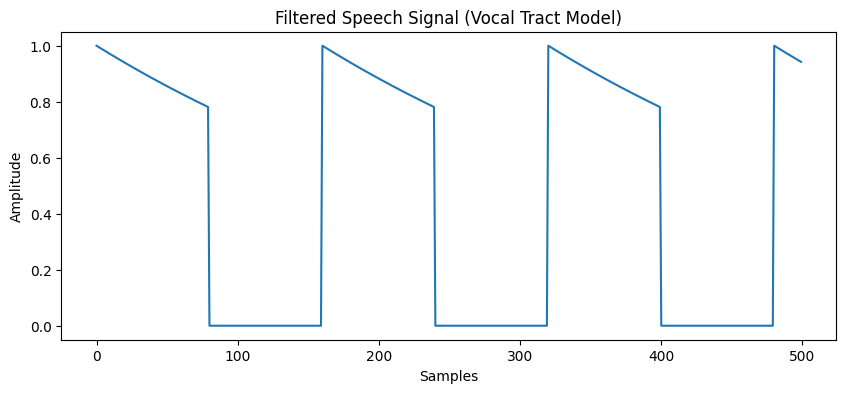

In [ ]:
def apply_vocal_tract_filter(source_signal, formants, bandwidths, sampling_rate=16000):
  """Applies a vocal tract filter to the source signal."""
  b, a = generate_vocal_tract_filter(formants, bandwidths, sampling_rate)
  filtered_signal = lfilter(b, a, source_signal)
  return filtered_signal

formants = [730, 1090, 2440]
bandwidths = [50, 50, 50]
sampling_rate = 16000

filtered_speech = apply_vocal_tract_filter(source_signal, formants, bandwidths, sampling_rate)

plt.figure(figsize=(10, 4))
plt.plot(filtered_speech[:500])
plt.title('Filtered Speech Signal (Vocal Tract Model)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()


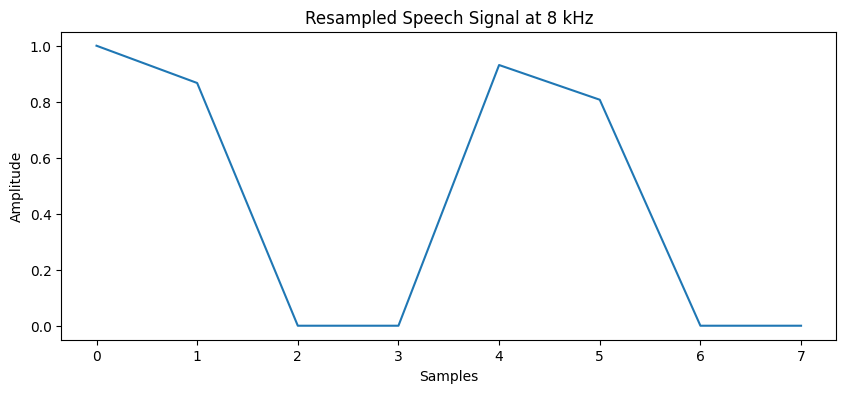

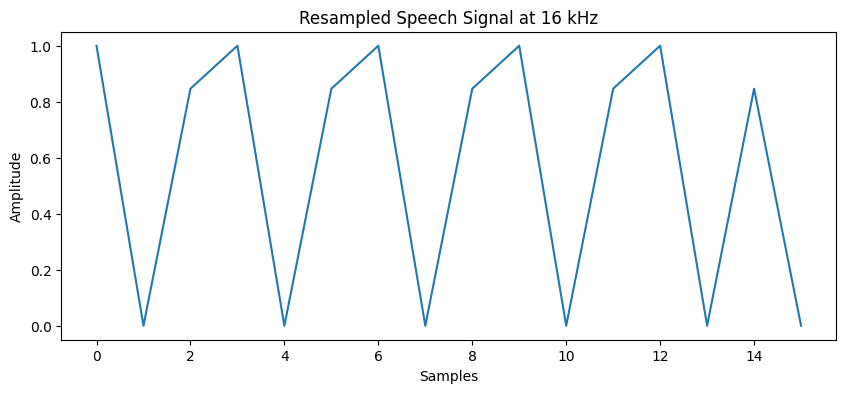

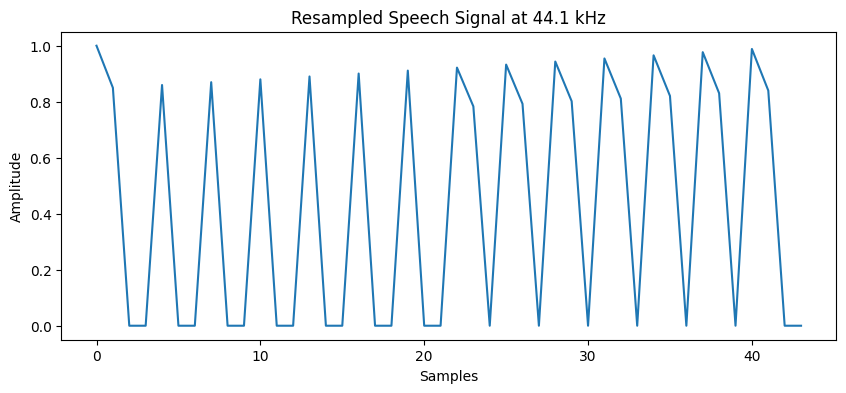

In [ ]:
sampling_rates = [8, 16, 44.1]

for sampling_rate in sampling_rates:
  duration = len(filtered_speech) / 16000
  new_length = int(duration * sampling_rate)
  resampled_speech = np.interp(np.linspace(0, len(filtered_speech), new_length), np.arange(len(filtered_speech)), filtered_speech)

  plt.figure(figsize=(10, 4))
  plt.plot(resampled_speech[:500])
  plt.title(f'Resampled Speech Signal at {sampling_rate} kHz')
  plt.xlabel('Samples')
  plt.ylabel('Amplitude')
  plt.show()


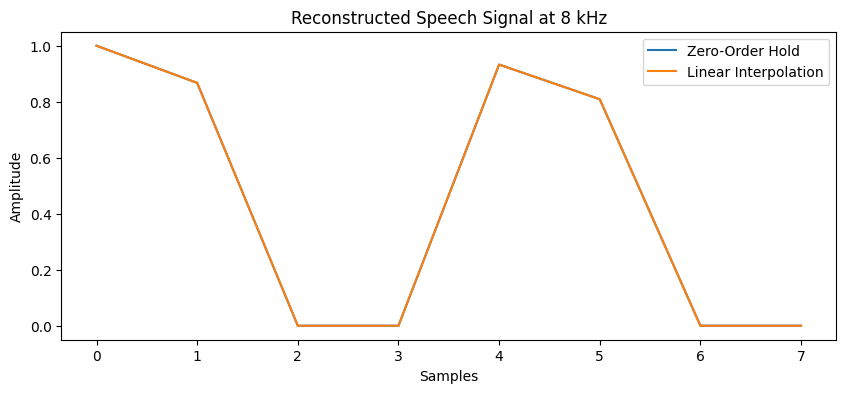

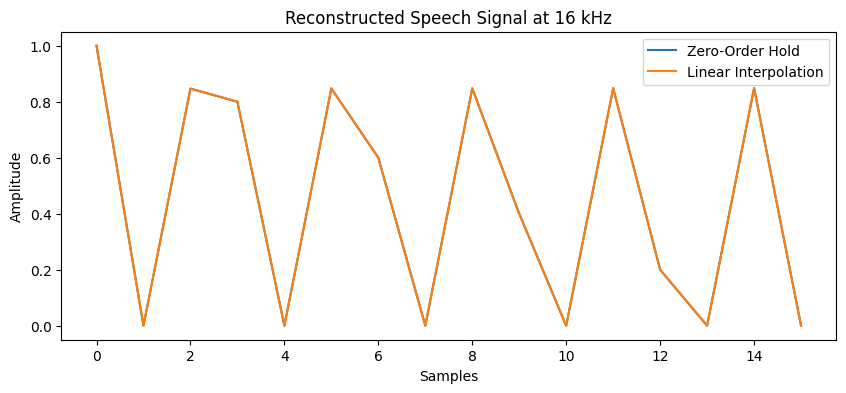

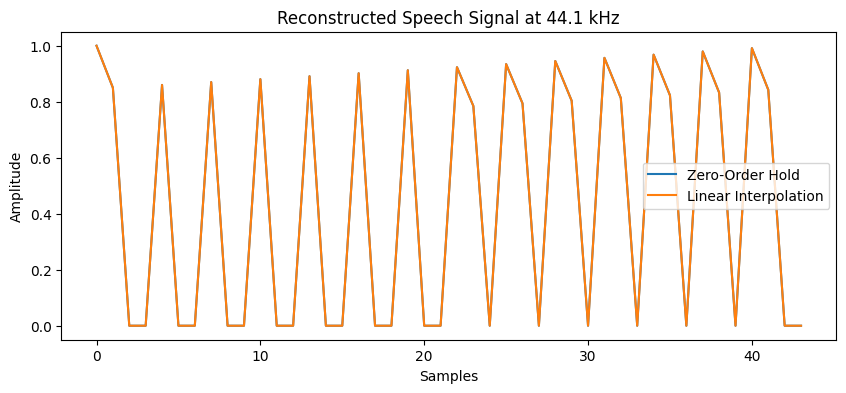

In [ ]:
def reconstruct_signal(signal, original_sampling_rate, new_sampling_rate, method='linear'):
  duration = len(signal) / original_sampling_rate
  new_length = int(duration * new_sampling_rate)
  new_time = np.linspace(0, duration, new_length)
  original_time = np.linspace(0, duration, len(signal))

  if method == 'zero_order':
    reconstructed_signal = np.interp(new_time, original_time, signal, left=signal[0], right=signal[-1])
  elif method == 'linear':
    reconstructed_signal = np.interp(new_time, original_time, signal)
  else:
    raise ValueError("Invalid interpolation method specified.")

  return reconstructed_signal


for sampling_rate in sampling_rates:
  reconstructed_speech_zoh = reconstruct_signal(filtered_speech, 16000, sampling_rate, method='zero_order')
  reconstructed_speech_linear = reconstruct_signal(filtered_speech, 16000, sampling_rate, method='linear')

  plt.figure(figsize=(10, 4))
  plt.plot(reconstructed_speech_zoh[:500], label='Zero-Order Hold')
  plt.plot(reconstructed_speech_linear[:500], label='Linear Interpolation')
  plt.title(f'Reconstructed Speech Signal at {sampling_rate} kHz')
  plt.xlabel('Samples')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.show()


In [ ]:
def calculate_mse(original_signal, reconstructed_signal):
    min_length = min(len(original_signal), len(reconstructed_signal))
    return np.mean((original_signal[:min_length] - reconstructed_signal[:min_length]) ** 2)

for sampling_rate in sampling_rates:
  reconstructed_speech_zoh = reconstruct_signal(filtered_speech, 16000, sampling_rate, method='zero_order')
  reconstructed_speech_linear = reconstruct_signal(filtered_speech, 16000, sampling_rate, method='linear')

  mse_zoh = calculate_mse(filtered_speech, reconstructed_speech_zoh)
  mse_linear = calculate_mse(filtered_speech, reconstructed_speech_linear)

  print(f"Sampling Rate: {sampling_rate}kHz")
  print(f"  MSE (Zero-Order Hold): {mse_zoh}")
  print(f"  MSE (Linear Interpolation): {mse_linear}")


Sampling Rate: 8kHz
  MSE (Zero-Order Hold): 0.49250310535506736
  MSE (Linear Interpolation): 0.49250310535506736
Sampling Rate: 16kHz
  MSE (Zero-Order Hold): 0.4295107500501338
  MSE (Linear Interpolation): 0.4295107500501338
Sampling Rate: 44.1kHz
  MSE (Zero-Order Hold): 0.4469012451288357
  MSE (Linear Interpolation): 0.4469012451288357


 1. Source-Filter Model Creation:
In speech processing, the source-filter model breaks down the process into two parts: the source and the filter. The source produces the initial sound, either as a periodic waveform for voiced speech or as noise for unvoiced speech. The filter simulates the resonances of the vocal tract (formants), which shape the raw sound into recognizable speech patterns. The frequency peaks seen in the graph represent these resonant frequencies. By separately modeling the source and filter, one can create or manipulate speech signals for tasks like synthesis, improving the naturalness and control over speech output.

 2. Effect of Sampling Rates:
The quality of signal representation depends significantly on the chosen sampling rate. According to the Nyquist-Shannon sampling theorem, the rate must be at least twice the maximum frequency in the signal to prevent aliasing and distortion. In speech, common sampling rates like 8 kHz capture basic intelligibility, while 16 kHz or higher offers greater clarity. Lower sampling rates fail to capture finer speech details, especially in higher frequencies, degrading the signal quality. Accurate sampling helps preserve critical elements like formants, ensuring the signal retains its natural characteristics and is more understandable.

 3. Signal Reconstruction:
Reconstructing a signal involves converting sampled data points back into a continuous waveform. Linear interpolation, as displayed in the plot, estimates values between points using straight lines, providing a simple but effective method to recreate the original signal. While suitable for moderate sampling rates, linear interpolation may miss high-frequency details in the signal. More advanced techniques, such as sinc interpolation, are more precise for band-limited signals. Ensuring accurate reconstruction is crucial to maintaining signal fidelity, especially for speech and audio processing, where smooth transitions between points are necessary for natural sound reproduction.